# HandSegNet Demo

This notebook shows how HandSegNet is used.

In [1]:
import os
import sys
import math

import torch
import torchvision
import torch.nn.functional as F
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc

model_path = os.path.abspath(os.path.join('..'))
if model_path not in sys.path:
    sys.path.append(model_path)
    
from colorhandpose3d.model.HandSegNet import HandSegNet
from colorhandpose3d.utils.general import *

## Initialization

Create the model and initialize the weights.

In [2]:
handsegnet = HandSegNet()

## Import weights from Tensorflow model

The original HandSegNet was implemented in Tensorflow. The pre-trained model weights need to be imported.

In [3]:
file_name = '/home/alex/dev/projects/hand3d-master/weights/handsegnet-rhd.pickle'
session = tf.Session()
exclude_var_list = list()
# exclude_var_list = ['HandSegNet/conv5_2/weights', 
#                     'HandSegNet/conv5_2/biases', 
#                     'HandSegNet/conv6_1/weights', 
#                     'HandSegNet/conv6_1/biases']

# read from pickle file
with open(file_name, 'rb') as fi:
    weight_dict = pickle.load(fi)
    weight_dict = {k: v for k, v in weight_dict.items() if not any([x in k for x in exclude_var_list])}
    
keys = [k for k, v in weight_dict.items() if 'HandSegNet' in k]
keys.sort()

# [print(k, weight_dict[k].shape) for k in keys]
    
for name, module in handsegnet.named_children():
    key = 'HandSegNet/{0}/'.format(name)
    if key + 'biases' in weight_dict:
        b = torch.tensor(weight_dict[key + 'biases'])
        w = torch.tensor(weight_dict[key + 'weights'])
        w = w.permute((3, 2, 0, 1))
        w = torch.nn.Parameter(w)
        b = torch.nn.Parameter(b)
        module.weight.data = w
        module.bias.data = b
        
torch.save(handsegnet.state_dict(), '/home/alex/dev/projects/colorhandpose3d-pytorch/saved/handsegnet.pth.tar')

## Test HandSegNet on a sample

Now that the pre-trained weights are loaded, test a sample from RHD.

In [4]:
def visualize_mask(img, mask):
    plt.figure(figsize=(16, 16))
    plt.subplot(121)
    plt.imshow(img)
    
    plt.subplot(122)
    plt.imshow(mask)
    plt.show()

tensor([[-3.9870, -3.9870, -3.9870, -3.9870, -4.0760, -4.2542, -4.4324, -4.6105,
         -4.7887, -4.9668],
        [-3.9870, -3.9870, -3.9870, -3.9870, -4.0760, -4.2542, -4.4324, -4.6105,
         -4.7887, -4.9668],
        [-3.9870, -3.9870, -3.9870, -3.9870, -4.0760, -4.2542, -4.4324, -4.6105,
         -4.7887, -4.9668],
        [-3.9870, -3.9870, -3.9870, -3.9870, -4.0760, -4.2542, -4.4324, -4.6105,
         -4.7887, -4.9668],
        [-4.1211, -4.1211, -4.1211, -4.1211, -4.2115, -4.3922, -4.5730, -4.7538,
         -4.9345, -5.1153],
        [-4.3893, -4.3893, -4.3893, -4.3893, -4.4823, -4.6683, -4.8543, -5.0403,
         -5.2263, -5.4123],
        [-4.6575, -4.6575, -4.6575, -4.6575, -4.7531, -4.9443, -5.1355, -5.3268,
         -5.5180, -5.7092],
        [-4.9256, -4.9256, -4.9256, -4.9256, -5.0239, -5.2203, -5.4168, -5.6133,
         -5.8097, -6.0062],
        [-5.1938, -5.1938, -5.1938, -5.1938, -5.2947, -5.4964, -5.6981, -5.8998,
         -6.1015, -6.3032],
        [-5.4620, -

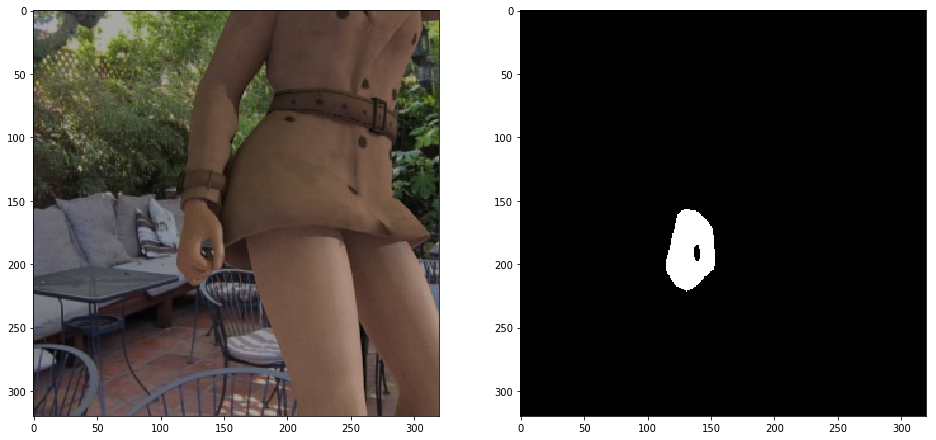

In [5]:
transform0 = torchvision.transforms.ToPILImage()
transform1 = torchvision.transforms.ToTensor()
transform2 = torchvision.transforms.Resize(256)
img = Image.open('/home/alex/Downloads/RHD_v1-1/RHD_published_v2/training/color/00007.png')

sample_original = transform1(img).unsqueeze(0)
sample = sample_original - 0.5
output = handsegnet.forward(sample)
mask = output.argmax(1).to(torch.float)
mask_img = transform0(mask.to(torch.float))
print(output[0, 1, :10, :10])

visualize_mask(img, mask_img)

# Refining the segmentation

The most likely object in the segmentation score map is found uding morphological dilation.

torch.Size([1, 2, 320, 320])


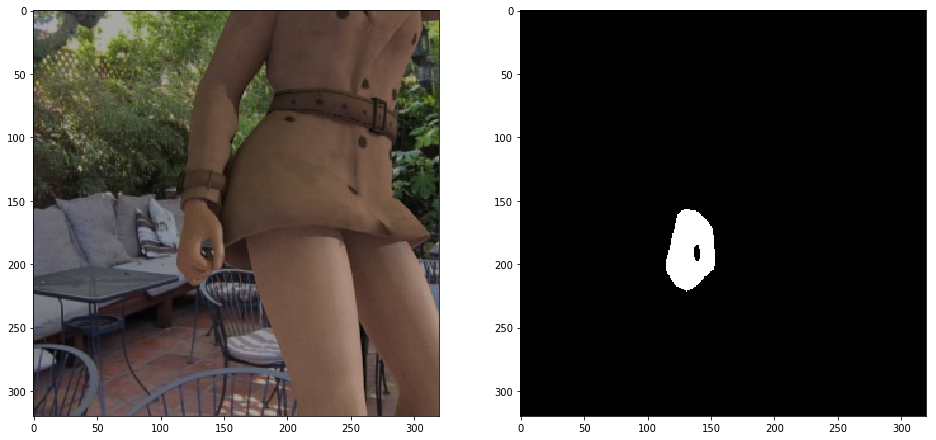

In [6]:
print(output.shape)
hand_mask = single_obj_scoremap(output, 21)
hand_mask_img = transform0(hand_mask[0])
visualize_mask(img, hand_mask_img)

## Calculate Bounding Box

The final step of the hand segmentation module is to calculate the bounding box and crop the hand from the original image.

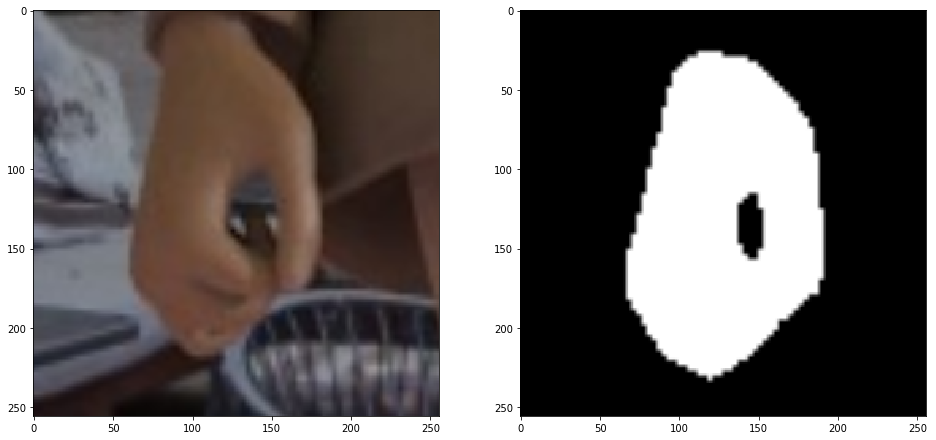

In [9]:
# Test the implementation of calc_center_bb
centers, bbs, crops = calc_center_bb(hand_mask)
crops = crops.to(torch.float32)
crop_size = 256

crops[0] *= 1.25
scale_crop = min(max(crop_size / crops[0], 0.25), 5.0)
image_crop = crop_image_from_xy(sample_original, centers, crop_size, scale_crop)
mask_crop = crop_image_from_xy(hand_mask, centers, crop_size, scale_crop)
img = transform0(image_crop[0])
mask_img = transform0(mask_crop[0])
visualize_mask(img, mask_img)